In [1]:
import utils_rag as ur
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_chroma import Chroma
from rich.markdown import Markdown as rich_Markdown

In [2]:
embed_model = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")

path_retriver = "retriever"

# Rutas de persistencia
persist_dir = path_retriver + "/chroma_db_v1"   # Directorio para Chroma
docstore_file = path_retriver + "/docstore_v1.pkl"         # Archivo para el docstore

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag"
                     , embedding_function=embed_model
                     ,persist_directory=persist_dir,)


# The storage layer for the parent documents
store = ur.load_docstore(docstore_file)
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [ ]:

import os
from langchain_google_genai import ChatGoogleGenerativeAI


if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = "..."

model = "gemini-2.0-flash"

llm = ChatGoogleGenerativeAI(
    model=model,
    temperature=0
)

def query_expansion_response(query,llm):
    query = query
    messages = [
        ("system", "Eres un útil asistente experto en diversos tipos de archivos de animales y inteligencia artificial."
        " Proporciona un ejemplo de respuesta a la pregunta, que podría encontrarse en un documento especifico, la respuesta que"
        "sea corta y concisa."),
        ("user", query),
    ]
    response = llm.invoke(messages)
    return response


In [4]:
def generar_citas(a_list, d_list, e_list,use_reranker=False):
    resultado = []
    for a_eval,d_val, e_val in zip(a_list,d_list, e_list):
        cita = {}
        if use_reranker:
            if d_val == 'Imagen':
                # Buscar el primer valor de a_list que coincide con d_val
                contenido = a_eval[1]
            elif d_val == 'Table':
                contenido = a_eval[1]
            else:
                contenido = e_val.get('text', '')
        else:
            if d_val == 'Imagen':
                # Buscar el primer valor de a_list que coincide con d_val
                contenido = a_eval
            elif d_val == 'Table':
                contenido = a_eval
            else:
                contenido = e_val.get('text', '')


        page_number = e_val.get('page_number', '')
        filename = e_val.get('filename', '')


        if contenido is not None:
            
            cita['contenido'] = contenido
            cita['page_number'] = page_number
            cita['filename'] = filename
            cita['file_type'] = d_val
            resultado.append(cita)
    
    contexto = "============================== Ventana de Contexto=======================================\n\n"
    for i,cita in enumerate(resultado):
        contexto += f"----------------------------Inicio Contexto {i+1}--------------------------------\n\n"
        contexto += f"Página: {cita['page_number']}\n\n"
        contexto += f"Archivo: {cita['filename']}\n\n"
        contexto += f"Tipo: {cita['file_type']}\n\n"
        contexto += f"Contenido: {cita['contenido']}\n\n"
        
        contexto += f"----------------------------Fin Contexto {i+1}--------------------------------\n\n"
    contexto += "==============================Fin Ventana de Contexto =======================================\n\n"

    
    return resultado, contexto



In [5]:
# VERSION 3
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
import utils_rag as ur
from pydantic import BaseModel, Field, validator
import re

class PageInfo(BaseModel):
    file_name: str
    page_numbers: List[int]

class CitationContext(BaseModel):
    context_id: str
    file_name: str
    page_numbers: List[int]

class State(TypedDict):
    query_original: str
    query_final: str
    context: str
    citations_raw: List  # Raw citations from document retrieval
    citations: List[Dict]  # Processed citations used in response
    use_query_expansion: bool
    use_reranker: bool
    answer: str
    check_citations: bool
    check_answer: bool
    validation_attempts: int
    citation_range_attempts: int
    cost: float
    model: str

# Step 1: Query Expansion Node
def query_expansion(state: State) -> State:

    llm = ChatGoogleGenerativeAI(
    model=state['model'],
    temperature=0
    )
    """Potentially expand the query if use_query_expansion is True."""
    if state["use_query_expansion"]:
        expanded_query = query_expansion_response(state["query_original"],llm).content

        state['cost'] += ur.estimar_costo(expanded_query, state['model'])        
        state["query_final"] = f"{state['query_original']} {expanded_query}"
    else:
        state["query_final"] = state["query_original"]
    
    return state

# Step 2: Retrieval Node
def document_retrieval(state: State) -> State:
    """Retrieve relevant documents."""
    a,b,c,d,e = ur.retrieved_documents(
        state["query_final"],
        retriever,
        n_results=5,
        reranker=state["use_reranker"],
        model_name_reranker='BAAI/bge-reranker-v2-m3',
        path_data="data/docs/",
        print_results=False
    )

    resultado, contexto = generar_citas(a, d, e, state["use_reranker"])
    
    state["context"] = contexto
    state["citations_raw"] = resultado
    state["validation_attempts"] = 0
    state["citation_range_attempts"] = 0
    
    return state

# Step 3: Response Generation Node
def generate_response(state: State) -> State:
    """Generate a response using context and query."""

    llm = ChatGoogleGenerativeAI(
    model=state['model'],
    temperature=0
    )
    
    prompt = ChatPromptTemplate.from_template("""
    You are a helpful assistant that provides accurate information based on the context provided.
    
    Context: {context}
    
    Question: {query}
    
    IMPORTANT INSTRUCTIONS:
    1. ONLY answer the question if the information is provided in the context above.
    2. If the question cannot be answered based on the context, explicitly state: 
       "No tengo suficiente información para responder a esta pregunta en base al contexto proporcionado."
    3. Provide a comprehensive answer based ONLY on the context.
    4. Include relevant citations when referring to contextual information, using the format "result [1], result [4]",
        where the number corresponds to the indices found between the words "Inicio Contexto 1" and "Fin Contexto 1" 
        and "Inicio Contexto 4" and "Fin Contexto 4" for example, you cannot use number with out of range mentioned in this expecific words.
    5. Do not make up information or use knowledge outside the provided context.
    
    Your response:
    """)
    
    chain = prompt | llm
    
    response = chain.invoke({
        "context": state["context"],
        "query": state["query_final"]
    })
    
    state["answer"] = response.content
    
    state['cost'] += ur.estimar_costo(response, state['model'])
    # Check if the answer indicates inability to answer
    state["check_answer"] = "No tengo suficiente información para responder a esta pregunta en base al contexto proporcionado." not in response.content.lower()
    
    return state

def validate_citation_ranges(state: State) -> State:
    """
    Check if all citations in the response are within the valid range (1-5)
    and fix them if needed.
    """
    # Check if we've already attempted the maximum number of tries
    if state["citation_range_attempts"] >= 3:
        return state
    
    # Increment the attempt counter
    state["citation_range_attempts"] += 1
    
    # Extract all citation numbers from the response
    answer = state["answer"]
    citation_pattern = r'\[(\d+)\]'
    citations = re.findall(citation_pattern, answer)
    
    # Convert to integers and check if any are out of range
    citation_numbers = [int(c) for c in citations]
    invalid_citations = [c for c in citation_numbers if c < 1 or c > 5]
    
    # If all citations are valid, return the state unchanged
    if not invalid_citations:
        return state
    
    # Otherwise, ask the LLM to fix the response
    fix_prompt = ChatPromptTemplate.from_template("""
    Your response contains citations that are outside the valid range. 
    Valid citation numbers are between 1 and 5, but your response includes: {invalid_citations}.
    
    Original context provided has these sections:
    {context_summary}
    
    Original response:
    {original_response}
    
    Please rewrite your response maintaining the same information but ensuring all citations 
    are within the valid range (1-5). Use the format [X] for citations, where X is a number 
    from 1 to 5 corresponding to the relevant context section.
    
    Revised response:
    """)
    
    # Create a summary of the available contexts
    context_parts = state["context"].split("Inicio Contexto")
    context_summary = []
    for i in range(1, 6):  # Assuming we have contexts 1 through 5
        if f"Inicio Contexto {i}" in state["context"]:
            # Extract a brief snippet from each context
            context_text = state["context"].split(f"Inicio Contexto {i}")[1].split(f"Fin Contexto {i}")[0]
            snippet = context_text[:100] + "..." if len(context_text) > 100 else context_text
            context_summary.append(f"Context {i}: {snippet}")
    
    chain = fix_prompt | llm
    
    result = chain.invoke({
        "invalid_citations": invalid_citations,
        "context_summary": "\n".join(context_summary),
        "original_response": state["answer"]
    })

    state['cost'] += ur.estimar_costo(result, state['model'])
    
    # Update the answer with the fixed response
    state["answer"] = result.content
    
    # Check if we still have invalid citations
    new_citations = re.findall(citation_pattern, state["answer"])
    new_citation_numbers = [int(c) for c in new_citations]
    new_invalid_citations = [c for c in new_citation_numbers if c < 1 or c > 5]
    
    # If we still have invalid citations and haven't reached max attempts, recursively try again
    if new_invalid_citations and state["citation_range_attempts"] < 3:
        return validate_citation_ranges(state)
    
    return state

def extract_used_citations(state: State) -> State:
    """Extract citations used in the response and identify which context sources were used."""
    
    answer = state["answer"]
    # Find all citations in the format [X]
    citation_pattern = r'\[(\d+)\]'
    used_citations = re.findall(citation_pattern, answer)
    used_citation_indices = [int(idx) for idx in used_citations]
    
    # Get unique citation indices
    unique_indices = list(set(used_citation_indices))
    unique_indices.sort()  # Sort for consistent ordering
    
    # If no citations found, return empty list
    if not unique_indices:
        state["citations"] = []
        return state
    
    # Create a prompt for the LLM to structure the citations
    format_prompt = ChatPromptTemplate.from_template("""
    You need to create a structured list of citations based on the information below:
    
    Used citation indices: {indices}
    context used: {raw_data}
    
    Create a list of dictionaries where each dictionary has a single key in the format "Contexto X" 
    where X is the citation number. The value of each key should be a dictionary with:
    - file_name: The name of the file
    - page_numbers: A list of page numbers
    
    For example:
    [
        {{"Contexto 3": {{"file_name": "document.pdf", "page_numbers": [2, 23, 42]}}}}
    ]
    
    ONLY include citations that were actually used in the response (indices: {indices}).
    Return ONLY the Python list representation, nothing else.
    """)
    
    chain = format_prompt | llm
    
    # Only include raw citations that were actually used
    relevant_raw_citations = []
    for idx in unique_indices:
        if 0 <= idx-1 < len(state["citations_raw"]):
            citation = state["citations_raw"][idx-1]
            citation_info = {"index": idx, "data": citation}
            relevant_raw_citations.append(citation_info)
    
    # Generate structured citations
    result = chain.invoke({
        "indices": unique_indices,
        "raw_data": state["context"] 
    })
    
    state['cost'] += ur.estimar_costo(result, state['model'])
    # Extract the Python code from the response
    citation_code = result.content
    if "```python" in citation_code:
        citation_code = citation_code.split("```python")[1].split("```")[0].strip()
    elif "```" in citation_code:
        citation_code = citation_code.split("```")[1].split("```")[0].strip()
    
    try:
        # Execute the code to get the citations list
        citation_locals = {}
        exec(f"citations = {citation_code}", {}, citation_locals)
        state["citations"] = citation_locals["citations"]
    except Exception:
        # Fallback to parsing using careful string manipulation
        try:
            import ast
            state["citations"] = ast.literal_eval(citation_code)
        except Exception:
            state["citations"] = []
    
    return state

def validate_citations(state: State) -> dict:
    """Validate the citation structure using Pydantic."""
    
    if state["validation_attempts"] >= 3:
        # If we've reached max attempts, simply return without validation
        state["check_citations"] = False
        return state
    
    state["validation_attempts"] += 1
    
    if not state["citations"]:
        state["check_citations"] = False
        return state
    
    try:
        # Try to validate each citation entry
        validated_citations = []
        
        for citation_dict in state["citations"]:
            # Each item should be a dictionary with a single key
            if not isinstance(citation_dict, dict) or len(citation_dict) != 1:
                raise ValueError("Each citation must be a dictionary with exactly one key")
            
            context_key = list(citation_dict.keys())[0]
            citation_data = citation_dict[context_key]
            
            if not context_key.startswith("Contexto "):
                raise ValueError(f"Citation key must be in format 'Contexto X', got {context_key}")
            
            # Validate the citation data structure
            if not isinstance(citation_data, dict):
                raise ValueError(f"Citation data for {context_key} must be a dictionary")
            
            if "file_name" not in citation_data or "page_numbers" not in citation_data:
                raise ValueError(f"Citation data for {context_key} must contain 'file_name' and 'page_numbers'")
            
            if not isinstance(citation_data["page_numbers"], list):
                raise ValueError(f"'page_numbers' for {context_key} must be a list")
            
            # Use Pydantic for final validation
            page_info = PageInfo(
                file_name=citation_data["file_name"],
                page_numbers=citation_data["page_numbers"]
            )
            
            # If validation passes, add to validated list
            validated_entry = {context_key: {"file_name": page_info.file_name, "page_numbers": page_info.page_numbers}}
            validated_citations.append(validated_entry)
        
        # Update state with validated citations
        state["citations"] = validated_citations
        state["check_citations"] = True
        
    except Exception as e:
        # If validation fails, retry with a clearer prompt
        if state["validation_attempts"] < 3:
            # Create a prompt to fix the structure
            fix_prompt = ChatPromptTemplate.from_template("""
            The citation structure is invalid. Error: {error}
            
            Please fix the citation structure to match this format:
            [
                {{"Contexto X": {{"file_name": "document.pdf", "page_numbers": [1, 2, 3]}}}}
            ]
            
            Where X is the citation number, file_name is a string, and page_numbers is a list of integers.
            
            Raw citation data: {raw_data}
            Used citation indices: {indices}
            
            Return ONLY the Python list representation, nothing else.
            """)
            
            # Extract citation indices again
            answer = state["answer"]
            citation_pattern = r'\[(\d+)\]'
            used_citations = re.findall(citation_pattern, answer)
            used_citation_indices = [int(idx) for idx in used_citations]
            unique_indices = list(set(used_citation_indices))
            
            # Get relevant raw citations
            relevant_raw_citations = []
            for idx in unique_indices:
                if 0 <= idx-1 < len(state["citations_raw"]):
                    citation = state["citations_raw"][idx-1]
                    citation_info = {"index": idx, "data": citation}
                    relevant_raw_citations.append(citation_info)
            
            # Try to fix the structure
            chain = fix_prompt | llm
            result = chain.invoke({
                "error": str(e),
                "indices": unique_indices,
                "raw_data": relevant_raw_citations
            })
            state['cost'] += ur.estimar_costo(result, state['model'])
            # Extract the Python code from the response
            citation_code = result.content
            if "```python" in citation_code:
                citation_code = citation_code.split("```python")[1].split("```")[0].strip()
            elif "```" in citation_code:
                citation_code = citation_code.split("```")[1].split("```")[0].strip()
            
            try:
                # Execute the code to get the fixed citations list
                citation_locals = {}
                exec(f"citations = {citation_code}", {}, citation_locals)
                state["citations"] = citation_locals["citations"]
                # Recursively validate the fixed structure
                return validate_citations(state)
            except Exception:
                try:
                    # Fallback to parsing using careful string manipulation
                    import ast
                    state["citations"] = ast.literal_eval(citation_code)
                    # Recursively validate the fixed structure
                    return validate_citations(state)
                except Exception:
                    state["check_citations"] = False
        else:
            state["check_citations"] = False
    
    return state

# Create the graph
def create_rag_graph():
    # Initialize the workflow
    workflow = StateGraph(State)
    
    # Add nodes
    workflow.add_node("query_expansion", query_expansion)
    workflow.add_node("document_retrieval", document_retrieval)
    workflow.add_node("generate_response", generate_response)
    workflow.add_node("validate_citation_ranges", validate_citation_ranges)
    workflow.add_node("extract_citations", extract_used_citations)
    workflow.add_node("validate_citations", validate_citations)
    
    # Create the edges
    workflow.set_entry_point("query_expansion")
    workflow.add_edge("query_expansion", "document_retrieval")
    workflow.add_edge("document_retrieval", "generate_response")
    workflow.add_edge("generate_response", "validate_citation_ranges")
    workflow.add_edge("validate_citation_ranges", "extract_citations")
    workflow.add_edge("extract_citations", "validate_citations")
    workflow.add_edge("validate_citations", END)
    
    # Compile the graph
    app = workflow.compile()
    return app

# Function to run the RAG workflow
def run_rag(query, use_query_expansion=False, use_reranker=True):
    app = create_rag_graph()
    
    result = app.invoke({
        "query_original": query,
        "use_query_expansion": use_query_expansion,
        "use_reranker": use_reranker,
        "model": "gemini-2.0-flash",
        "cost": 0
    })
    
    return result

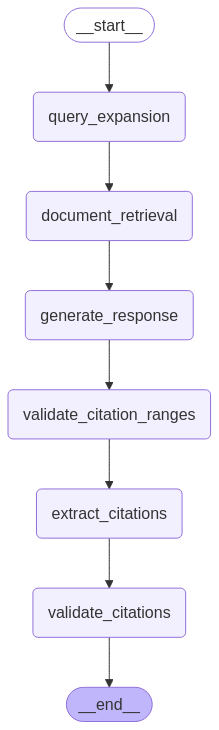

In [6]:
from IPython.display import Image, display
display(Image(create_rag_graph().get_graph().draw_mermaid_png()))

In [13]:
query = "que modelo se ocupa para la clasificacion de enfermedades"

# Run with default settings (no query expansion, with reranker)
result = run_rag(query)

rich_Markdown(result['answer'])


Para la clasificación de enfermedades, se utiliza un modelo de dos pasos que consta de un módulo de Reconocimiento 
de Entidades Nombradas (NER) y un motor de búsqueda [5].                                                           

 • Primer módulo (NER): Este módulo se encarga de identificar las menciones de enfermedades en el texto libre      
   ingresado [3, 5]. Utiliza una red neuronal profunda con tres capas principales: una capa de "embedding apilada" 
   para transformar el texto en vectores, una capa de codificación con una red neuronal recurrente (BiLSTM) para   
   capturar el contexto de las palabras, y una capa de clasificación que aplica un campo aleatorio condicional     
   (CRF) para etiquetar cada palabra y determinar si corresponde a una enfermedad [1, 3].                          
 • Segundo módulo (Motor de búsqueda): Este módulo asigna códigos CIE-10 a las enfermedades identificadas por el   
   NER [3, 5]. Utiliza Apache Elasticsearch para encontrar similitudes entre la mención de la enfermedad y los     
   códigos CIE-10, basándose en un índice que contiene descripciones y sinónimos de enfermedades extraídos de      
   diversas fuentes [3].

In [17]:
for i in result['citations']:
    print(i.keys())

dict_keys(['Contexto 3'])
dict_keys(['Contexto 5'])


Costo estimado: 0.00 USD


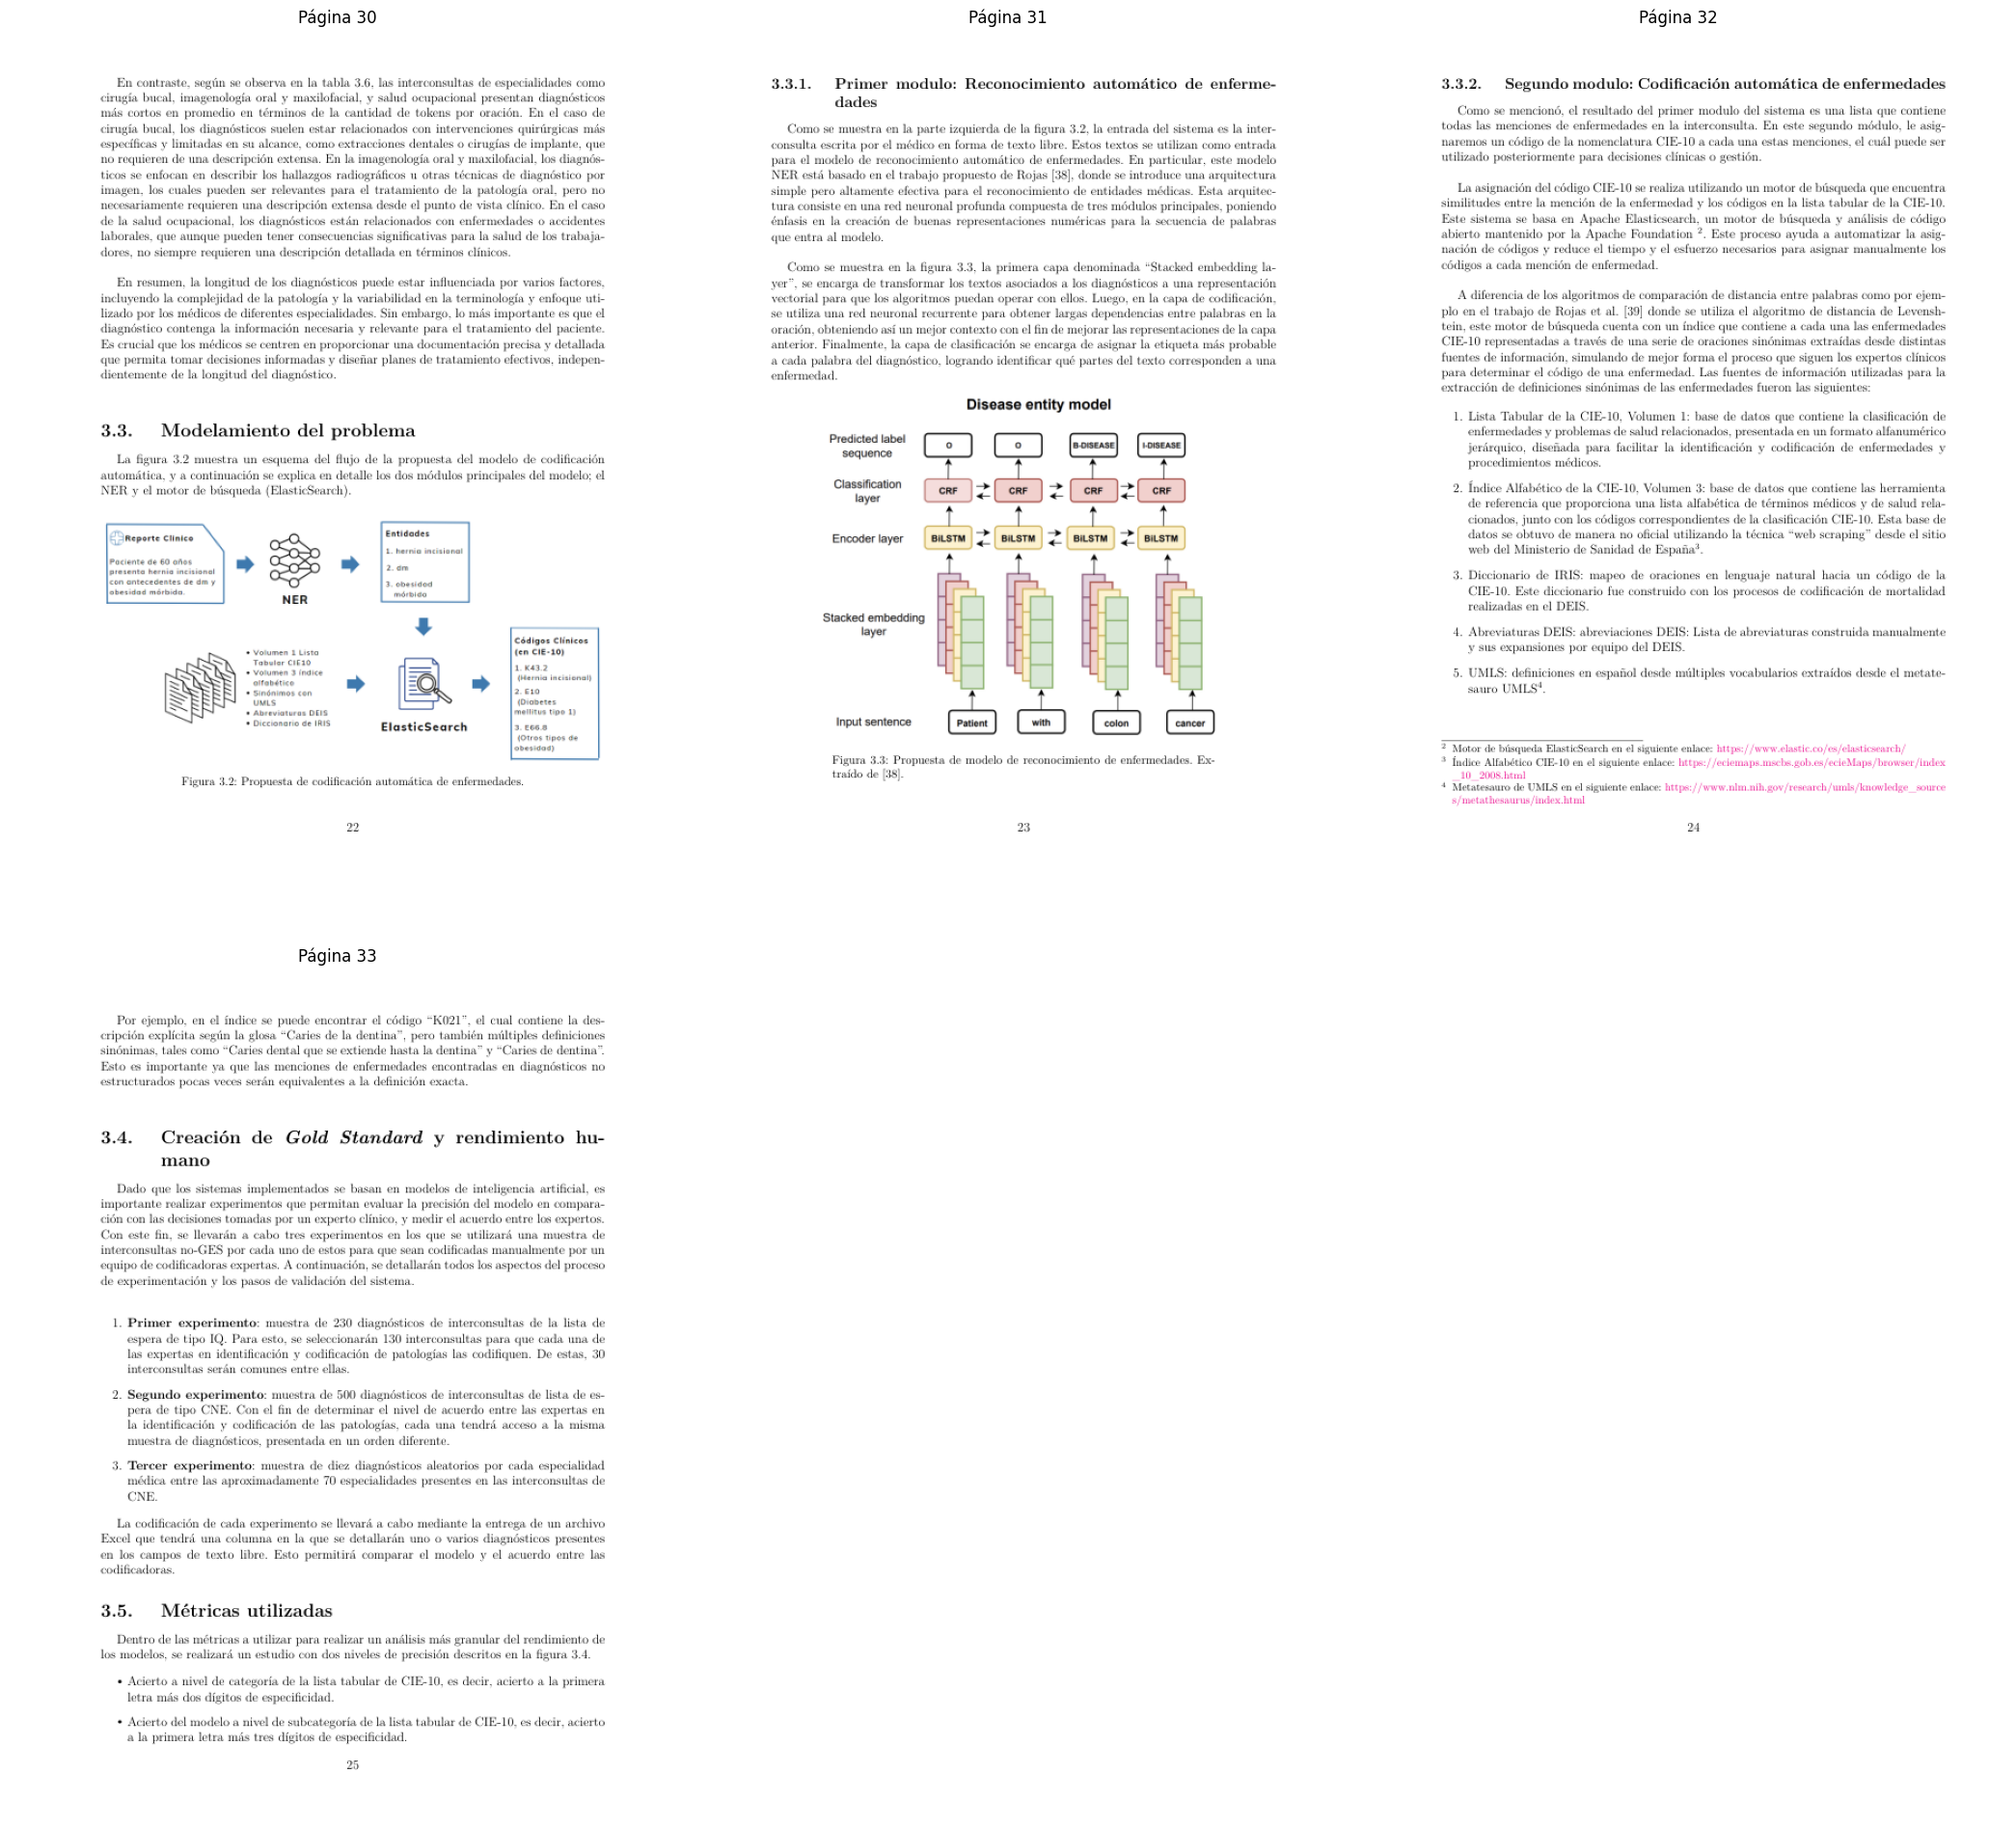

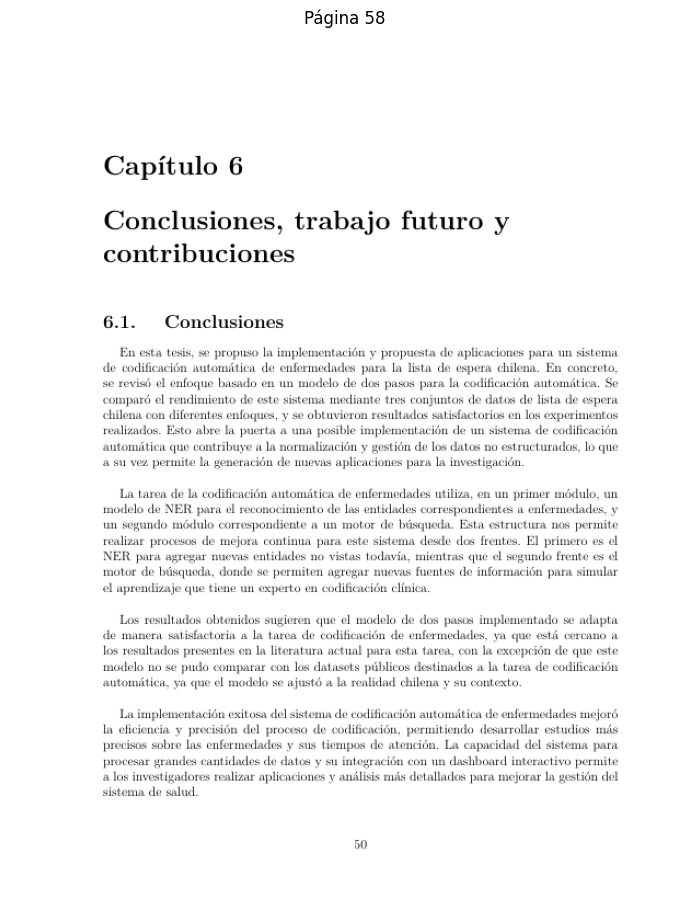

In [14]:
print(f"Costo estimado: {result['cost']:.2f} USD")
path_datos = "data/docs/"

for i in result['citations']:
    resultado = list(i.values())
    ur.plot_multiple_pages(path_datos + resultado[0]['file_name'], resultado[0]['page_numbers'])